In [192]:
import numpy as np
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
from pycbc.types import TimeSeries
import emcee
import corner
import tqdm as tqdm

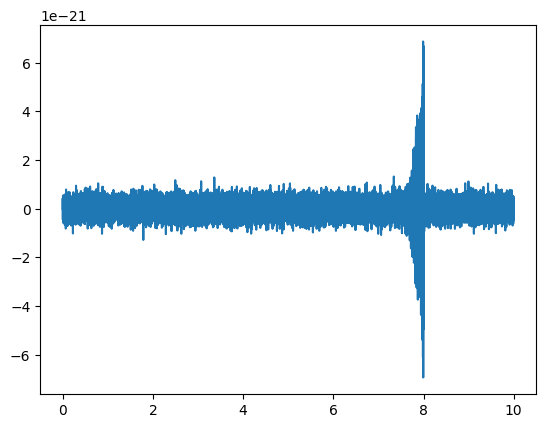

In [193]:
# loading in data 
time_data, strain_data = np.loadtxt('data/PE_white_data_ts.txt',skiprows = 1).T
time_noise, strain_noise = np.loadtxt('data/PE_white_noise_ts.txt',skiprows=1).T

strain_noise_ts = TimeSeries(strain_noise, delta_t = time_noise[1]-time_noise[0])
strain_data_ts = TimeSeries(strain_data,delta_t=time_data[1]-time_data[0])

plt.plot(time_data,strain_data)

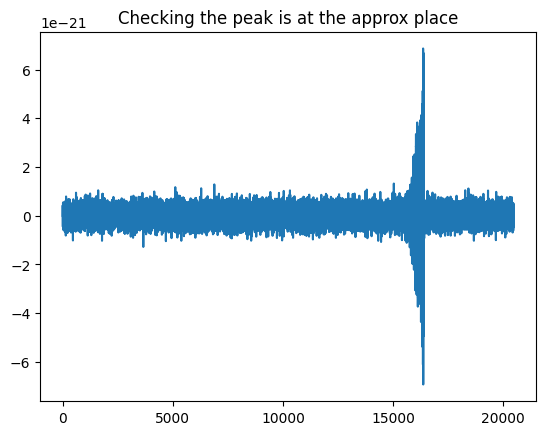

The peak of the strain is located at [16366]


Text(0.5, 1.0, 'Making sure the peak is centred and windowed')

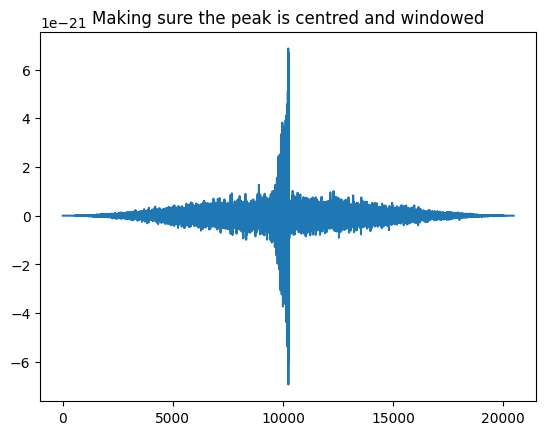

In [194]:
# rolling to the middle and windowing and rolling back to 8 seconds
mid_point = len(strain_data) //2
final_point = len(strain_data)
peaks,_ = find_peaks(strain_data,height = 6.86e-21,distance = 1000)

plt.plot(strain_data)
plt.title('Checking the peak is at the approx place')
plt.show()
print('The peak of the strain is located at',peaks)

roll_amount = mid_point - peaks
centred = np.roll(strain_data,int(roll_amount))
delta_t = time_data[1] - time_data[0]
window = signal.windows.hann(len(centred))
centred_windowed_signal = centred*window

plt.plot(centred_windowed_signal)
plt.title('Making sure the peak is centred and windowed')

/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-0.049995 -0.049985 -0.049975 ...  0.049975  0.049985  0.049995]


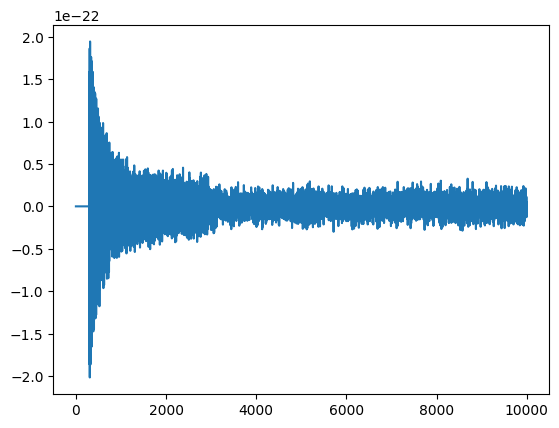

In [203]:
#defining main data and shaping

data_freq = np.fft.rfft(centred_windowed_signal) *delta_t  #data in frequency space
freq_array = np.fft.rfftfreq(len(time_data),delta_t)# frequency arry for fouier transfomred signal 
data_freq = data_freq*np.exp(-2*np.pi*1j*freq_array*3) #shifting the centred signal back to the 8 second point 

noise_freq = np.fft.rfft(strain_noise) # strain noise in frequency space
noise = noise_freq

delta_f = freq_array[1]-freq_array[0] # sample frequency 


# cut off frequecny values as this is what signal is between
high_cutoff = 1000
low_cutoff = 30

#turning these frequencies into an index
high_limit = 1000/delta_f+1
low_limit = 30/delta_f

# limiiting the 
data_final = data_freq[:int(high_limit)]
freq_final = freq_array[:int(high_limit)]

data_final[freq_final < low_cutoff] = 0 # cutting off bewlow 30 hertz

# data_final = data_final*np.exp(-2*np.pi*1j*freq_final*3)


nperseg = len(freq_final)
psd_hann = scipy.signal.windows.hann(nperseg) # defining the type of window applied to psd
freqs_hann,psd_hann = scipy.signal.welch(noise, fs=delta_f, nperseg=nperseg, window='hann') # creating the psd 

new_freqs = np.linspace(min(freqs_hann),max(freqs_hann),10001) # defining new frequency array to interpolate over
interp_psd = interp1d(freqs_hann,psd_hann,kind = 'linear',bounds_error = False , fill_value='extrapolate')
psd_interpolated = interp_psd(new_freqs) # interpolating osd
# print(len(psd_hann[0]),len(freq_final))

# interp_psd = interp1d(freq_final[:5], psd_hann, kind='linear', bounds_error=False, fill_value="extrapolate")
# psd_interpolated = interp_psd(freq_final)

plt.plot(data_final)

# print(len(psd_interpolated))
# print('The length of the psd is',len(psd_interpolated),'The length do the data is',len(data_final))
# temp_freq = np.fft.rfftfreq(len(data_final),delta_t)
# len(temp_freq)
print(new_freqs)

In [196]:
# time = np.linspace(0,10,20000)
# # plt.plot( freq_final , (data_final))
# plt.show()
# # plt.plot(freq_final , np.fft.irfft(psd_interpolated)[5000:15001])

In [197]:
# # plt.plot(new_freqs,np.fft.irfft(psd_interpolated))
# # plt.ylim(6.5e-62+5.92224952e-51,6.8e-62+5.92224952e-51)

# print(len(data_final))

In [198]:
def template(theta,f_lower,f_higher):
    time_shift = theta 

    hplus , hc = get_fd_waveform(mass1 = 32,mass2 = 30,distance = 100,approximant='IMRPhenomPv2',f_lower=f_lower, f_higher=f_higher, delta_t = delta_t,delta_f = delta_f)
    hplus_freq = hplus.sample_frequencies
    # return hplus
    # hplus = hplus * np.exp(-2*np.pi*1j*hplus_freq*time_shift)

    hplus= hplus.cyclic_time_shift(time_shift)
    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
        return hplus
    # below is code to fix it but dont think i should have it.
    if len(hplus) == len(data_final):
        return hplus
    
    if len(hplus) < len(data_final):
        pad_amount = len(data_final) - len(hplus)
        hplus = np.pad(hplus,(0,pad_amount),'constant',constant_values=(0,0))
        return hplus

/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


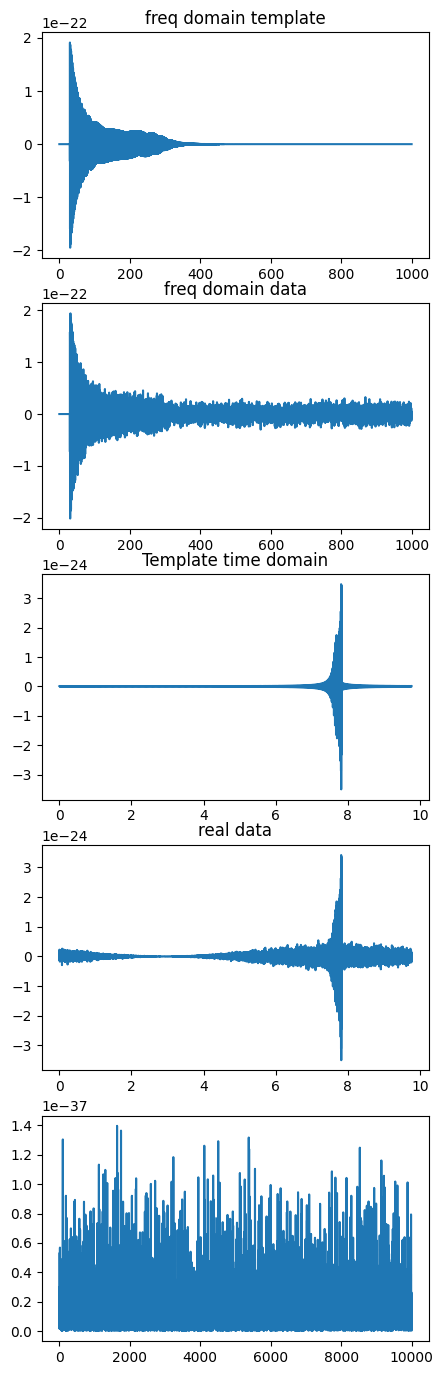

In [199]:
theta = 8.0073
temp = template(theta,30,1000)#0.00873
# print(temp)
plt.figure(figsize = (5,17))
plt.subplot(511)
plt.plot(freq_final,temp)
plt.title('freq domain template')

plt.subplot(512)
plt.plot(freq_final, data_final)
plt.title('freq domain data')

plt.subplot(513)
plt.plot(time_data[:20000],np.fft.irfft(temp))
plt.title('Template time domain')

plt.subplot(514)
plt.plot(time_data[:20000],np.fft.irfft(data_final))
plt.title('real data')

plt.subplot(515)
plt.plot(psd_interpolated)

# print(len(data_final),len(np.fft.irfft(temp)),len(time_data))

#so data isnt in the same place as template, this is the data centrted windowed and time shifted back and invered ft
# the template is the inverse fourier transform of the teplate


In [200]:
def log_prior(theta):
    time_shift = theta
    
    if not(7.9< time_shift < 8.2):
        return -np.inf
    
    # if not(70 < D < 150):
    #     return -np.inf
    
    return 0.0

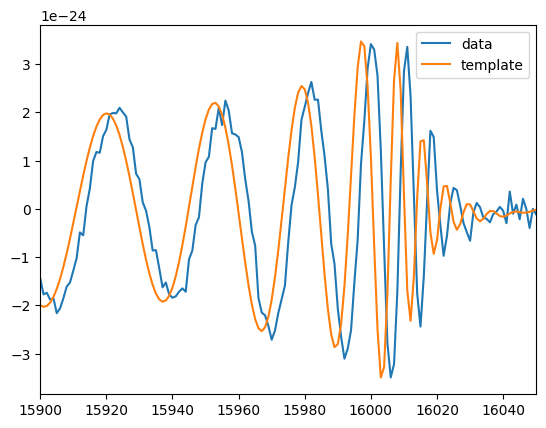

In [201]:
plt.plot((np.fft.irfft(data_final)),label = 'data')
# plt.plot(np.fft.irfft(temp* np.exp(-2*np.pi*1j*freq_final*((18/2048)+8))),label = 'template')
plt.plot(np.fft.irfft(temp),label = 'template')
plt.xlim(15900,16050)
plt.legend()

In [187]:
def log_like(theta, fft_signal,noise): #,delta_t,delta_f):
    # time_shift = theta

    
    temp = template(theta, 30, 1000)

    residual = fft_signal - temp*delta_t#* np.exp(-2j*np.pi*freq_final*time_shift)
    likelihood = -2/10 * np.sum(np.abs(residual) ** 2 / noise)
    return likelihood


In [164]:
1
log_like(theta,data_final,psd_interpolated)

-0.0020501270367907958

# ---------------- TRYING GRID -----------------------------------

In [90]:
def template(time_shift,delta_t,f_lower,f_higher,delta_f):
    # D,time_shift = theta 

    hplus , hc = get_fd_waveform(mass1 = 32,mass2 = 30,distance = 100,approximant='IMRPhenomPv2',f_lower=f_lower, f_higher=f_higher, delta_t = delta_t,delta_f = delta_f)
    hplus_freq = hplus.sample_frequencies
    # return hplus
    hplus = hplus * np.exp(-2*np.pi*1j*hplus_freq*((time_shift)))

    # hplus= hplus.cyclic_time_shift(time_shift)
    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
        return hplus
    # below is code to fix it but dont think i should have it.
    if len(hplus) == len(data_final):
        return hplus
    
    if len(hplus) < len(data_final):
        pad_amount = len(data_final) - len(hplus)
        hplus = np.pad(hplus,(0,pad_amount),'constant',constant_values=(0,0))
        return hplus

In [91]:
def log_like(D, fft_signal,noise ,delta_t,delta_f):
    
    temp = template(D, delta_t, 30, 1000,delta_f)

    residual = fft_signal - temp#* np.exp(-2*np.pi*1j*freq_final*time_shift)
    sum = np.abs(residual)**2/noise
    return -2/10* np.sum((sum))

In [92]:
ngrid = 500
t = np.linspace(8,8.2,ngrid)
log_likelihood_grid = np.zeros(ngrid)


for i in (range(ngrid)):

    log_likelihood_grid[i] = log_like(t[i], data_final, psd_interpolated, delta_t,delta_f)

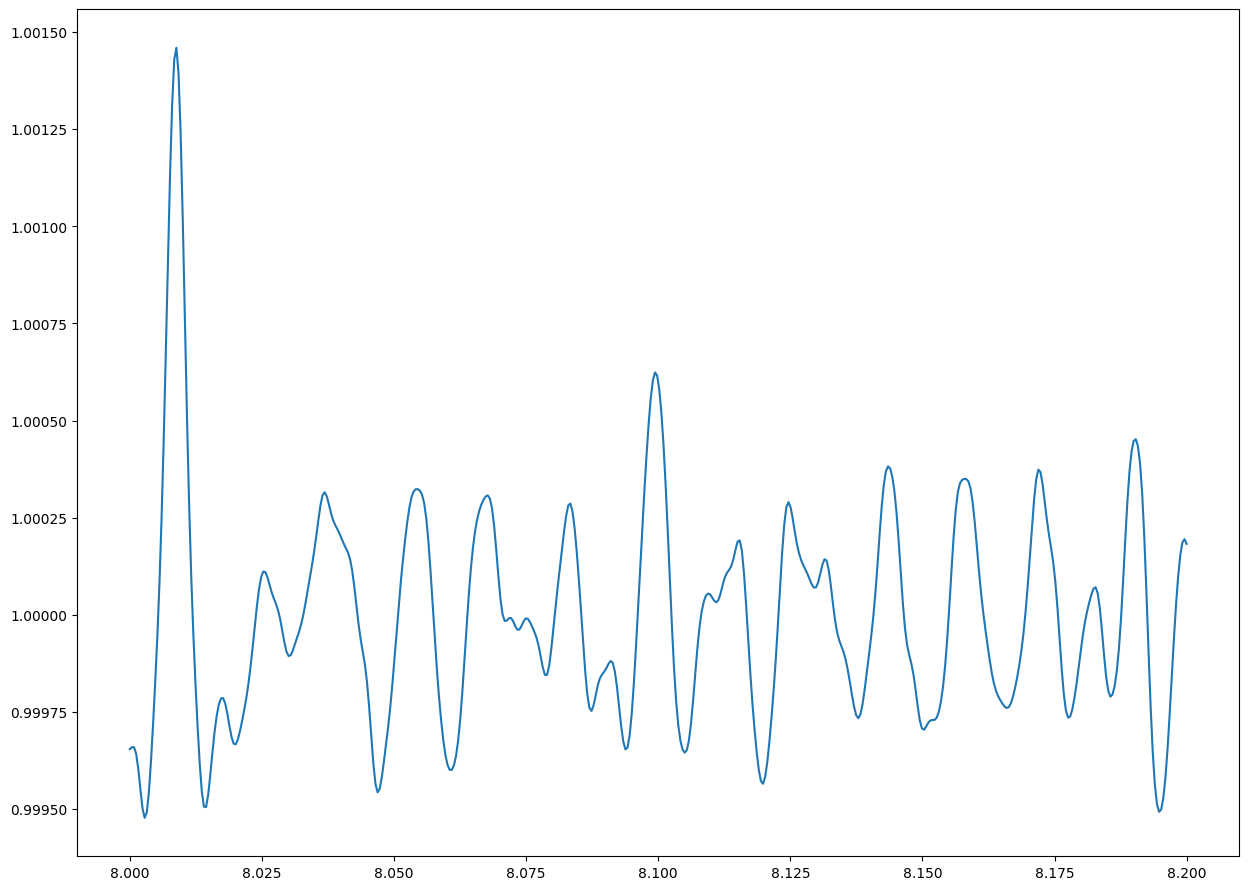

In [93]:
plt.figure(figsize = (15,11))
plt.plot(t,np.exp(log_likelihood_grid-np.mean(log_likelihood_grid)))
# plt.axvline(32,color='r',label='$m=1$')
plt.show()

# ------------------------------------------------------------------------------------

In [188]:
def log_posterior(theta, data,noise_data):#,delta_t,delta_f):
    # print(f"Theta: {theta}")
    log_pri = log_prior(theta)
    if np.isinf(log_pri):  # if prior is -inf, return stragiht away
        return log_pri
    return log_pri + log_like(theta, data, noise_data)#,delta_t,delta_f)

In [189]:
theta = np.linspace(8,8.2,200)
# log_posterior(theta,data_final,psd_interpolated)

likes = []
for i in theta:
    like = log_posterior(i,data_final,psd_interpolated)
    likes.append(like)

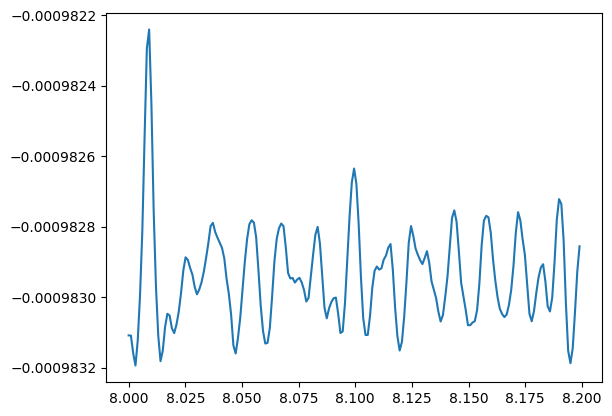

In [190]:
plt.plot(theta,likes)

In [191]:
nwalkers = 10
ndim = 1

initial = np.empty((nwalkers, ndim)) 
# initial[:, 0] = np.random.uniform(30, 34, size=nwalkers)
# initial[:, 1] = np.random.uniform(28, initial[:, 0])
# initial[:, 0] = np.random.uniform(70, 150, size=nwalkers)
initial[:, 0] = np.random.uniform(7.9, 8.2, size=nwalkers)

# print(initial)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_final,psd_interpolated))#,delta_t,delta_f))#,moves= emcee.moves.StretchMove())

state = sampler.run_mcmc(initial, nsteps = 1000,progress = True)
sampler.reset()

nsteps = 1000
sampler.run_mcmc(initial, nsteps,progress = True)


emcee: Exception while calling your likelihood function:
  params: [8.03794291]
  args: (array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, ...,
       -1.18299762e-24+3.19143979e-24j, -3.46673093e-24-5.26035796e-24j,
        4.13975449e-24+3.87939754e-24j]), array([1.92183136e-39, 1.96388440e-38, 1.38400710e-38, ...,
       2.57889630e-40, 5.01514844e-39, 1.84615614e-39]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_46162/467105291.py", line 6, in log_posterior
    return log_pri + log_like(theta, data, noise_data)#,delta_t,delta_f)
  File "/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_46162/1039366412.py", line 5, in log_like
    temp = template(theta, 30, 1000)
  File "/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_46162/2867463917.py", line 9, in template
    hplus= hplus.cyclic_time_shift(time_shift)
  File "/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/pycbc/types/array.py", line 81, in noreal
    return func(self, *args, **kwargs)
  File "/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/pycbc/types/frequencyseries.py", line 508, in cyclic_time_shift
    data.st

TypeError: in method 'new_LIGOTimeGPS', argument 1 of type 'struct tagLIGOTimeGPS const *'
Additional information:
Wrong number or type of arguments for overloaded function 'new_LIGOTimeGPS'.
  Possible C/C++ prototypes are:
    tagLIGOTimeGPS::tagLIGOTimeGPS(REAL8)
    tagLIGOTimeGPS::tagLIGOTimeGPS(INT4)
    tagLIGOTimeGPS::tagLIGOTimeGPS(INT4,INT8)
    tagLIGOTimeGPS::tagLIGOTimeGPS(char const *)
    tagLIGOTimeGPS::tagLIGOTimeGPS()
    tagLIGOTimeGPS::tagLIGOTimeGPS(struct tagLIGOTimeGPS const *)


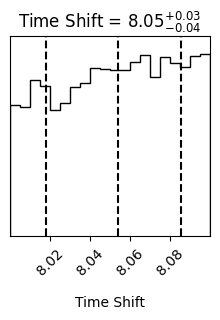

In [163]:

samples = sampler.flatchain

figure = corner.corner(samples,labels = ['Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)

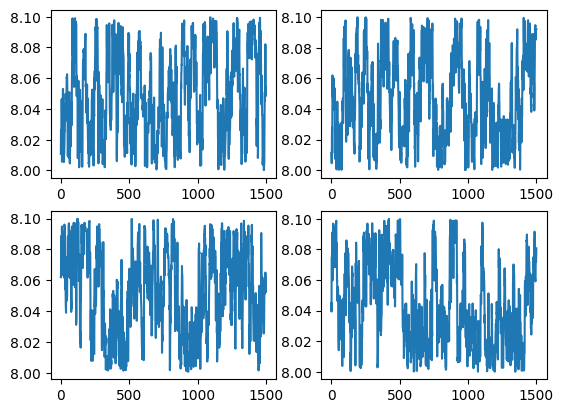

In [131]:
samples = sampler.get_chain()


plt.subplot(221)
plt.plot(samples[:,4,0])
plt.subplot(222)
plt.plot(samples[:,3,0])
plt.subplot(223)
plt.plot(samples[:,2,0])
plt.subplot(224)
plt.plot(samples[:,1,0])

# Tring mass and distance

In [163]:
def template(theta,delta_t,f_lower,f_higher,time_shift,delta_f):
    M1,M1,D = theta 

    hplus , hc = get_fd_waveform(mass1 = M1,mass2 = M1,distance = D,approximant='IMRPhenomPv2',f_lower=f_lower, f_higher=f_higher, delta_t = delta_t,delta_f = delta_f)
    hplus_freq = hplus.sample_frequencies
    # return hplus
    hplus = hplus * np.exp(-2*np.pi*1j*hplus_freq*time_shift)

    # hplus= hplus.cyclic_time_shift(time_shift)
    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
        return hplus
    # below is code to fix it but dont think i should have it.
    if len(hplus) == len(data_final):
        return hplus
    
    if len(hplus) < len(data_final):
        pad_amount = len(data_final) - len(hplus)
        hplus = np.pad(hplus,(0,pad_amount),'constant',constant_values=(0,0))
        return hplus

In [164]:
def log_prior(theta):
    M1,M2,D = theta
    
    if not (30 < M1 < 34):
        return -np.inf 
    
    if not (28 < M2 < M1):
        return -np.inf
    
    if not(50 < D < 120):
        return -np.inf
    
    return 2*np.log(D)

In [165]:
def log_like(theta, fft_signal,noise ,delta_t,delta_f):

    
    temp = template(theta, delta_t , 30, 1000,8,delta_f)

    residual = fft_signal*delta_t - temp*delta_t
    sum = np.abs(residual)**2/noise
    return -2 / 10 * np.sum((sum))

In [168]:
nwalkers = 10
ndim = 3

initial = np.empty((nwalkers, ndim)) 
initial[:, 0] = np.random.uniform(30, 34, size=nwalkers)
initial[:, 1] = np.random.uniform(28, initial[:, 0])
initial[:, 2] = np.random.uniform(50, 120, size=nwalkers)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_final,psd_interpolated,delta_t,delta_f))#,moves= emcee.moves.StretchMove())

state = sampler.run_mcmc(initial, nsteps = 1500,progress = True)
sampler.reset()

nsteps = 500
sampler.run_mcmc(initial, nsteps,progress = True)

100%|██████████| 500/500 [00:42<00:00, 11.85it/s]


State([[ 33.75147672  28.68109719  89.89930185]
 [ 33.41896584  32.60826396  61.73306573]
 [ 31.45598535  30.80844322 107.07620737]
 [ 33.89936758  28.4957104   91.38694182]
 [ 33.18201247  28.00061483  96.83397412]
 [ 30.7922693   28.93589664 112.38185585]
 [ 32.52701964  30.50732576 105.29489033]
 [ 31.21331151  29.81337039 112.58321261]
 [ 32.79446017  28.09094409 115.26023282]
 [ 33.99310907  28.49817473  65.01293352]], log_prob=[8.99639745 8.24465632 9.34609865 9.02922231 9.14501296 9.44282208
 9.31254684 9.4464023  9.49340206 8.34818959], blobs=None, random_state=('MT19937', array([2257942864,  998797706, 2998355247, 1348244971,  258812439,
       1707773822, 1306107374,  427107969, 3529868583, 4059129973,
       2538535058, 2191986323,  472090329, 3779413673,  299732797,
       3575587961, 1965620578, 2348849141,  696969010, 2932559731,
       4119398631, 3589916374, 1147312442, 2993219383, 2902191769,
       1308527262, 1718673260, 3947241443, 2816814214, 2602388195,
         4

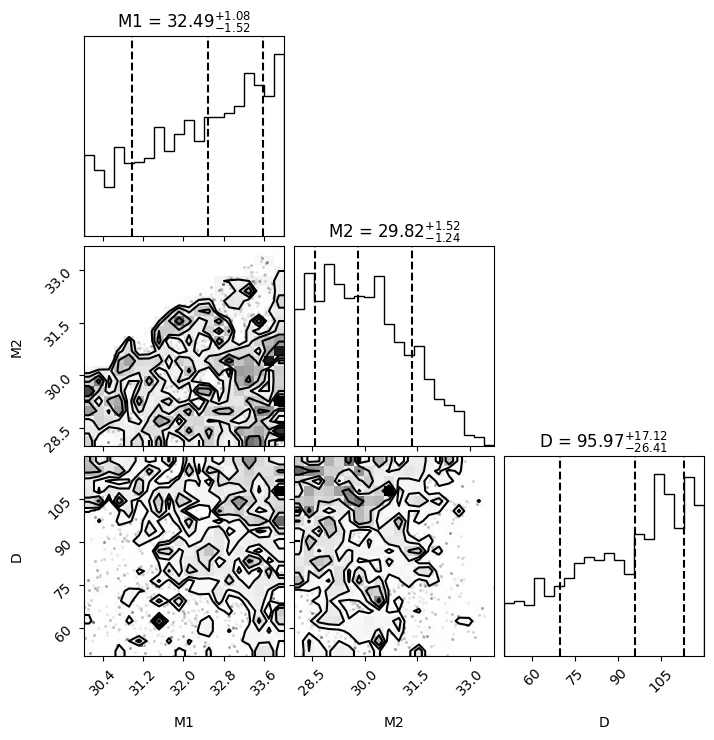

In [169]:
samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','D'],quantiles=[0.16,0.5,0.84],show_titles = True)